<a href="https://colab.research.google.com/github/bobby-he/Neural_Tangent_Kernel/blob/master/Neural_tangent_kernel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/bobby-he/Neural_Tangent_Kernel.git

Cloning into 'Neural_Tangent_Kernel'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 23 (delta 7), reused 15 (delta 5), pack-reused 0
Unpacking objects: 100% (23/23), done.


In [0]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
import seaborn as sns
sns.set()

In [0]:
from Neural_Tangent_Kernel.src.NTK_net import LinearNeuralTangentKernel, FourLayersNet, train_net, circle_transform

In [0]:
use_cuda = True if torch.cuda.is_available() else False


# Reproducing the experiments in the neural tangent kernel paper.



## 6.2



### Define the input and target data

In [0]:
gamma_data = torch.tensor(np.array([-2.2, -1, 1, 2.2]))

In [0]:
target_data = torch.tensor(np.array([-0.4, -0.2, 0.3, 0.3])).float()

In [0]:
input_data = circle_transform(gamma_data)

In [0]:
if use_cuda:
  input_data = input_data.cuda()
  target_data = target_data.cuda()

### Create Plot

In [0]:
gamma_vec = torch.tensor(np.linspace(-np.pi, np.pi, 100))
circle_points = circle_transform(gamma_vec)
if use_cuda:
  circle_points = circle_points.cuda()

Completed initialisation 0
Completed initialisation 1
Completed initialisation 2
Completed initialisation 3
Completed initialisation 4
Completed initialisation 5
Completed initialisation 6
Completed initialisation 7
Completed initialisation 8
Completed initialisation 9


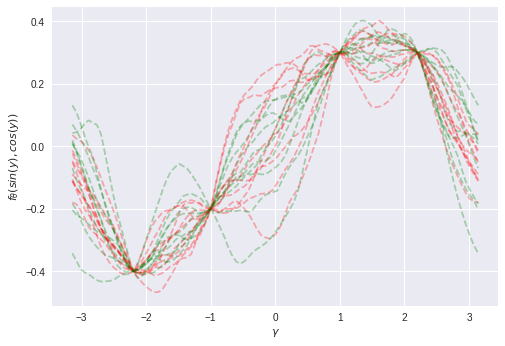

In [11]:
for i in range(10):
  # 1000 width first
  net = FourLayersNet(1000)
  if use_cuda:
    net = net.cuda()
  train_net(net, 1000, input_data, target_data)
  output_vec = net(circle_points).cpu()
  plt.plot(gamma_vec.numpy(), output_vec.detach().numpy(), color='red',
           linestyle='--', alpha = 0.3)
 
# 50 width
  net = FourLayersNet(50)
  if use_cuda:
    net = net.cuda()
  train_net(net, 1000, input_data, target_data)
  output_vec = net(circle_points).cpu()
  plt.plot(gamma_vec.numpy(), output_vec.detach().numpy(), color='green',
           linestyle='--', alpha = 0.3)
  
  print('Completed initialisation {}'.format(i))
  
plt.xlabel('$\gamma$')
plt.ylabel('$f_{ \\theta}(sin(y),cos(y))$')
plt.show()
   
   

### Getting the GP process plot is harder (I think) because of a lack of a standard kernel, here is an attempt but it is probably horrifically inefficient

In [0]:
n_pts=50
n_width = 5000

In [0]:
# number of points in plot
grad_mat = torch.zeros((n_pts,4))
net = FourLayersNet(n_width)
if use_cuda:
  net.cuda()

In [0]:
gamma_test = torch.tensor(np.linspace(-np.pi,np.pi, n_pts))
initial_train = net(input_data) # this acts of f_0 on page 7 of NTK paper
initial_test = net(circle_transform(gamma_test).cuda())

In [0]:
train_net(net, 1000, input_data, target_data)

In [0]:
# saves gradient objects onto cpu, saves GPU memory
def cpu_tuple(tuple_obj):
  return tuple([obj.cpu() for obj in tuple_obj])

In [0]:
grad_list = []
for gamma in gamma_data:
  circle_pt = circle_transform(gamma)
  if use_cuda and torch.cuda.is_available():
    circle_pt = circle_pt.cuda()
  loss = net(circle_pt)
  grad_list.append(cpu_tuple(torch.autograd.grad(loss,net.parameters(), retain_graph = True)))

In [0]:
# grad_mat is kappa on p7 of NTK paper
for i, gamma in enumerate(gamma_test):
  circle_pt = circle_transform(gamma)
  if use_cuda and torch.cuda.is_available():
    circle_pt = circle_pt.cuda()
  loss = net(circle_pt)
  grads = cpu_tuple(torch.autograd.grad(loss,net.parameters(), retain_graph = True)) # extract NN gradients 
  for j in range(len(grad_list)):
    pt_grad = grad_list[j] # the gradients at the jth (out of 4) data point
    grad_mat[i, j] = sum([torch.sum(torch.mul(grads[u], pt_grad[u])) for u in range(len(grads))])

In [0]:
# let's create Ktilde matrix from p7 of NTK paper
tilde_mat = torch.zeros((4,4))
for i in range(4):
  grad_i = grad_list[i]
  for j in range(i+1):
    grad_j = grad_list[j]
    tilde_mat[i, j] = sum([torch.sum(torch.mul(grad_i[u], grad_j[u])) for u in range(len(grad_j))])
    tilde_mat[j, i] = tilde_mat[i, j]
    
tilde_inv = torch.inverse(tilde_mat)

In [0]:
temp_mat = torch.mm(grad_mat, tilde_inv)

In [36]:
temp_mat.device

device(type='cpu')

In [0]:
target_data = target_data.cpu()

In [0]:
mean_vec = torch.mm(temp_mat, target_data.unsqueeze(1)) #+ initial_test.cpu() - torch.mm(temp_mat, initial_train.cpu())

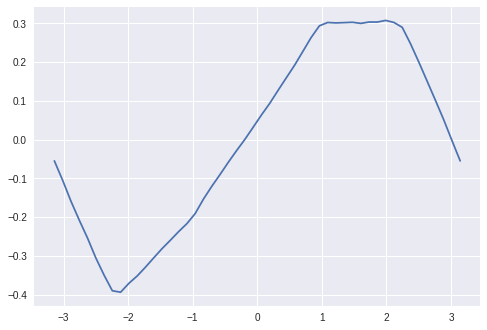

In [39]:
plt.plot(gamma_test.numpy(), mean_vec.detach().numpy())

### It remains to estimate sigma matrix

In [0]:
new_model = nn.Sequential(*(list(net.children())[:-1]))

In [0]:
new_model = nn.Sequential(new_model, nn.ReLU())

In [42]:
torch.mean(new_model(input_data), dim=1, keepdim=True)

tensor([[0.3014],
        [0.2933],
        [0.3042],
        [0.3014]], device='cuda:0', grad_fn=<MeanBackward0>)

In [0]:
sigma_testvtest = torch.mean(new_model(circle_transform(gamma_test).cuda())**2, dim = 1, keepdim=True) + torch.tensor(0.01) # n_pts x 1 dim vector 


In [44]:
sigma_testvtest.shape

torch.Size([50, 1])

In [52]:
sigma_testvtrain = torch.mm(new_model(circle_transform(gamma_test).cuda()),torch.t(new_model(input_data)))/5000 + torch.tensor(0.01) # n_pts x 4 dim matrix
sigma_testvtrain.shape

torch.Size([50, 4])

In [0]:
sigma_trainvtrain = torch.mm(new_model(input_data),torch.t(new_model(input_data)))/5000 + torch.tensor(0.01) # 4 x 4 dim matrix

In [0]:
variance_vec = sigma_testvtest.view(-1) -2 * torch.diag(torch.mm(sigma_testvtrain,torch.t(temp_mat.cuda()))) + torch.diag(torch.mm(temp_mat.cuda(), torch.mm(sigma_trainvtrain, torch.t(temp_mat.cuda()))))

In [0]:
variance_vec = variance_vec.cpu()

In [0]:
variance_vec.requires_grad

True

In [0]:
variance_vec.shape

torch.Size([20])

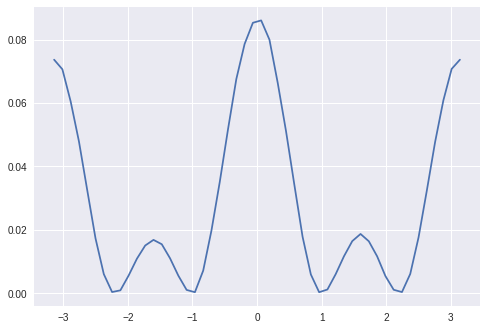

In [56]:
plt.plot(gamma_test.numpy(), variance_vec.detach().numpy())

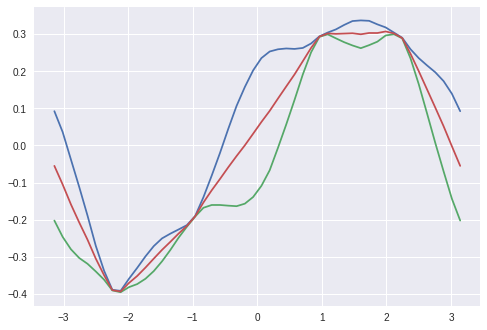

In [57]:
plt.plot(gamma_test.numpy(), mean_vec.view(-1).detach().numpy()+2*variance_vec.detach().numpy())
plt.plot(gamma_test.numpy(), mean_vec.view(-1).detach().numpy()-2*variance_vec.detach().numpy())
plt.plot(gamma_test.numpy(), mean_vec.view(-1).detach().numpy()+0*variance_vec.detach().numpy())